# COVID-19 Transfer Learning

Training a model for flu and then repurposing it for COVID

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential, Input
from sklearn.preprocessing import StandardScaler

from covid_flu import config, utils, time_series, plotting, models

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [428]:
df_flu = utils.load_flu_data()

In [574]:
df_covid = utils.load_covid_data()
display(df_covid.head())
display(df_covid.tail())

,date,state,cases
0,2020-01-21,Alabama,0.0
1,2020-01-22,Alabama,0.0
2,2020-01-23,Alabama,0.0
3,2020-01-24,Alabama,0.0
4,2020-01-25,Alabama,0.0


,date,state,cases
5770,2020-04-30,Wyoming,415.0
5771,2020-05-01,Wyoming,420.0
5772,2020-05-02,Wyoming,429.0
5773,2020-05-03,Wyoming,435.0
5774,2020-05-04,Wyoming,444.0


In [575]:
df_covid = df_covid[df_covid['cases'] >= 10]

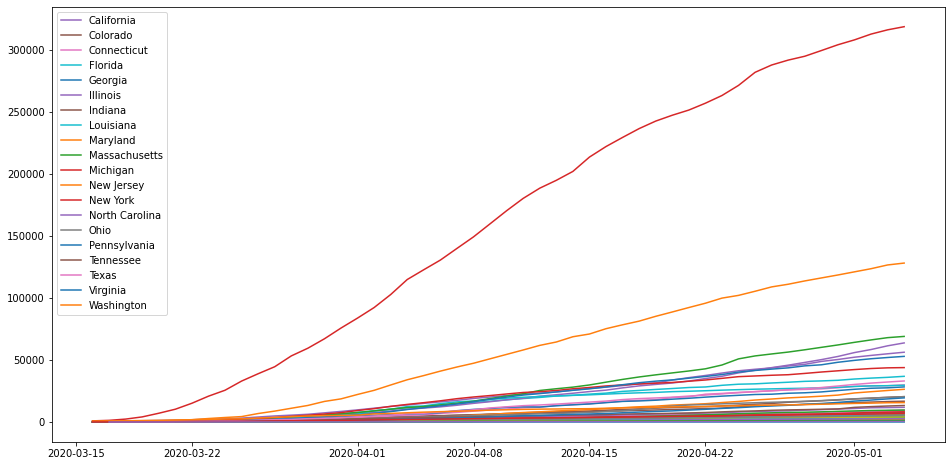

In [576]:
plt.figure(figsize=(16, 8))
# plt.yscale('log')
for state in df_covid['state'].unique():
    subset = df_covid.query('state == @state').query('date > @pd.to_datetime("2020-03-15")').query('cases > 10')
    if (subset['cases'] > 10000).any():
        plt.plot(subset['date'], subset['cases'], label=state)
    else:
        plt.plot(subset['date'], subset['cases'])
plt.legend()
plt.show()

## Preparing data for COVID and flu

In [210]:
HISTORY_SIZE = 25
TARGET_SIZE = 1
BATCH_SIZE = 64
TEST_SIZE = 0.3
PAD_VAL = -1

# Scaling
scaler_flu = StandardScaler()
scaler_covid = StandardScaler()
df_flu['wili'] = utils.scale_data(df_flu['wili'].values, scaler_flu)
df_covid['cases'] = utils.scale_data(df_covid['cases'].values, scaler_covid)

# Making train/val/test split
ds_train_flu, ds_val_flu, ds_test_flu, data_dict_flu = time_series.prepare_data(df_flu['wili'].values, 
                                                                                df_flu['state'].values,
                                                                                history_size=HISTORY_SIZE,
                                                                                target_size=TARGET_SIZE,
                                                                                batch_size=BATCH_SIZE,
                                                                                test_size=TEST_SIZE,
                                                                                pad_value=PAD_VAL)

ds_train_covid, ds_val_covid, ds_test_covid, data_dict_covid = time_series.prepare_data(df_covid['cases'].values, 
                                                                                        df_covid['state'].values,
                                                                                        history_size=HISTORY_SIZE,
                                                                                        target_size=TARGET_SIZE,
                                                                                        batch_size=BATCH_SIZE,
                                                                                        test_size=TEST_SIZE,
                                                                                        pad_value=PAD_VAL)

## Training the flu model

We are going to use a simple masked LSTM that predicts 5 days at a time using a history of at most 25 (to allow for more COVID info).

Some important ways in which the COVID and flu data differ from each other, which will need to be accounted for:

* Temporal resolution: Flu is weekly, COVID is daily
* Temporal completeness: Flu has ten years of full time series, whereas COVID only has a partial time series for most of this year
* Testing completeness: Although we can't be sure, the flu data are generally more reliable in terms of testing than COVID. The COVID data depend heavily on testing, which we should try to take into account in the model if at all possible
* Progression of epidemic: Flu tends to follow a clear seasonal pattern, whereas COVID is currently just following a roughly exponential/logistic curve

In [192]:
# No state embeddings for now... they don't seem to help
def make_padded_lstm_model(max_len,
                           target_len=5,
                           hidden_size=32,
                           mask_value=-1,
                           pre_output_dense_size=32):
    
    input_layer = Input(shape=(max_len, 1))
    
    base = Sequential([
        layers.LSTM(hidden_size, input_shape=(max_len, 1))
    ], name='base')

    head = Sequential([
        layers.Dense(pre_output_dense_size, input_shape=(hidden_size,), activation='relu'),
        layers.Dense(target_len)
    ], name='head')
    
    x = layers.Masking(mask_value=mask_value)(input_layer)   
    x = base(x)
    x = head(x)
    
    model = Model(input_layer, outputs=x)
    model.compile(optimizer='adam', loss='mse')
    return model

In [193]:
MAX_LEN = HISTORY_SIZE
HIDDEN_SIZE = 32
DENSE_SIZE = 32
EPOCHS = 5

model_flu = make_padded_lstm_model(MAX_LEN,
                                   target_len=TARGET_SIZE,
                                   hidden_size=HIDDEN_SIZE,
                                   mask_value=PAD_VAL,
                                   pre_output_dense_size=DENSE_SIZE)
model_flu.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 25, 1)]           0         
_________________________________________________________________
masking_7 (Masking)          (None, 25, 1)             0         
_________________________________________________________________
base (Sequential)            (None, 32)                4352      
_________________________________________________________________
head (Sequential)            (None, 15)                1551      
Total params: 5,903
Trainable params: 5,903
Non-trainable params: 0
_________________________________________________________________


Train for 243 steps, validate for 53 steps
Epoch 1/5
243/243 [==============================] - 10s 43ms/step - loss: 0.6529 - val_loss: 0.6798
Epoch 2/5
243/243 [==============================] - 6s 23ms/step - loss: 0.5069 - val_loss: 0.6263
Epoch 3/5
243/243 [==============================] - 6s 24ms/step - loss: 0.4748 - val_loss: 0.5967
Epoch 4/5
243/243 [==============================] - 6s 23ms/step - loss: 0.4540 - val_loss: 0.5947
Epoch 5/5
243/243 [==============================] - 6s 23ms/step - loss: 0.4359 - val_loss: 0.6101


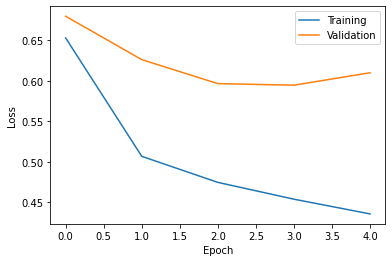

In [194]:
history_flu = model_flu.fit(ds_train_flu, validation_data=ds_val_flu, epochs=EPOCHS)
plotting.plot_history(history_flu)

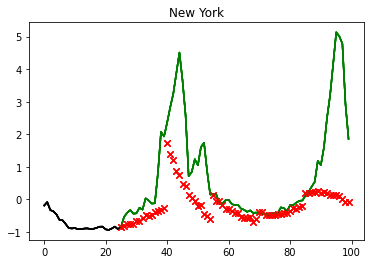

In [208]:
plotting.plot_state_predictions_multi(model_flu, data_dict_flu, 'New York', TARGET_SIZE, scaler=scaler_flu)

(311, 15) (311, 15)
RMSE = 0.5570662114368639


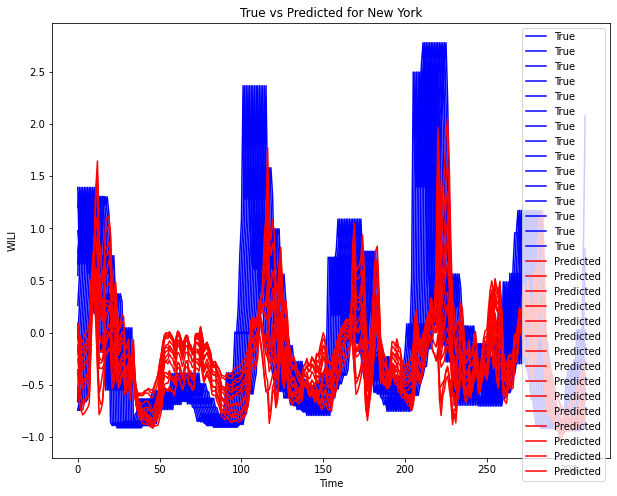

In [199]:
idxs = np.random.choice(len(X_test_flu), size=3)
plotting.plot_preds_for_state(data_dict_flu['X_train'], data_dict_flu['y_train'], data_dict_flu['states_train'],
                              model_flu, HISTORY_SIZE, 'New York')
plt.show()

## Training the COVID model

The flu model is comprised of two parts:

1. The recurrent part (the base), which can be seen as a feature extractor for the time series
2. The FCN part (the head) which can be seen as the prediction network

Given this abstraction, we can see what happens when we freeze the base and just allow the head to be fine-tuned on the COVID time series.

In [87]:
model_flu.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
masking_4 (Masking)          (None, 10, 1)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


In [99]:
def make_covid_model(model_flu):
    model_covid = tf.keras.models.clone_model(model_flu)
    
    # Set the base to be not trainable
    model_covid.get_layer('base').trainable = False
    
    # Set the head to be trainable
    model_covid.get_layer('head').trainable = True
    model_covid.compile(optimizer='adam', loss='mse')
    return model_covid

In [105]:
model_covid = make_covid_model(model_flu)
model_covid.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
masking_6 (Masking)          (None, 10, 1)             0         
_________________________________________________________________
base (Sequential)            (None, 32)                4352      
_________________________________________________________________
head (Sequential)            (None, 5)                 1221      
Total params: 5,573
Trainable params: 1,221
Non-trainable params: 4,352
_________________________________________________________________


In [259]:
data_dict_flu['X_train'].shape

(15900, 25, 1)

In [258]:
data_dict_flu['y_train'].shape

(15900, 5, 1)

Train for 60 steps, validate for 13 steps
Epoch 1/20
60/60 [==============================] - 2s 40ms/step - loss: 0.0398 - val_loss: 4.0506
Epoch 2/20
60/60 [==============================] - 1s 11ms/step - loss: 0.0198 - val_loss: 3.7281
Epoch 3/20
60/60 [==============================] - 1s 11ms/step - loss: 0.0171 - val_loss: 3.3588
Epoch 4/20
60/60 [==============================] - 1s 11ms/step - loss: 0.0150 - val_loss: 2.7793
Epoch 5/20
60/60 [==============================] - 1s 11ms/step - loss: 0.0125 - val_loss: 2.3153
Epoch 6/20
60/60 [==============================] - 1s 11ms/step - loss: 0.0101 - val_loss: 1.8296
Epoch 7/20
60/60 [==============================] - 1s 11ms/step - loss: 0.0079 - val_loss: 1.4560
Epoch 8/20
60/60 [==============================] - 1s 11ms/step - loss: 0.0064 - val_loss: 1.1014
Epoch 9/20
60/60 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.9340
Epoch 10/20
60/60 [==============================] - 1s 11ms/step -

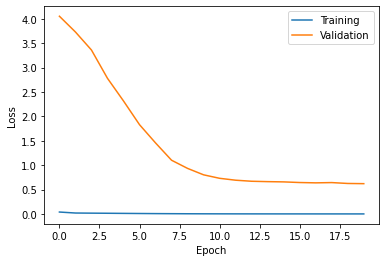

In [106]:
# Training
EPOCHS = 20
history_covid = model_covid.fit(ds_train_covid, validation_data=ds_val_covid, epochs=EPOCHS)
plotting.plot_history(history_covid)

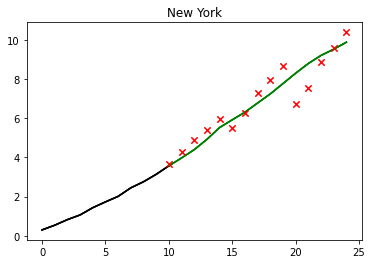

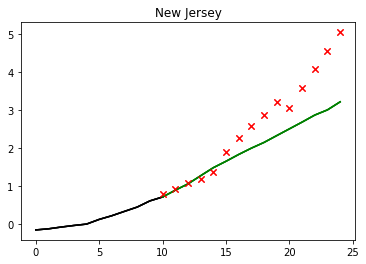

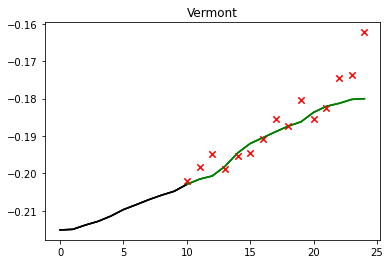

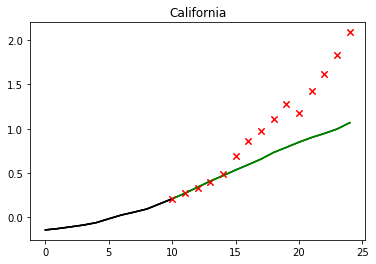

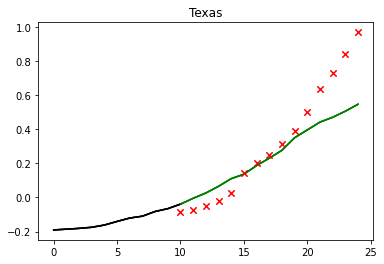

In [178]:
for s in ['New York', 'New Jersey', 'Vermont', 'California', 'Texas']:
    plot_state_predictions(model_covid, data_dict_covid, s, scaler_covid)
    plt.show()

## Using seq2seq model for transfer learning

In [587]:
HISTORY_SIZE = 25
TARGET_SIZE = 5
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
HIDDEN_SIZE = 32
PRE_OUTPUT_DENSE_SIZE = 32

scaler_flu = StandardScaler()
scaler_covid = StandardScaler()
df_flu['wili'] = utils.scale_data(df_flu['wili'].values, scaler_flu)
df_covid['cases'] = utils.scale_data(df_covid['cases'].values, scaler_covid)

scaler_flu = StandardScaler()
scaler_covid = StandardScaler()
df_flu['wili'] = utils.scale_data(df_flu['wili'].values, scaler_flu)
df_covid['cases'] = utils.scale_data(df_covid['cases'].values, scaler_covid)

# Making train/val/test split
ds_train_flu, ds_val_flu, ds_test_flu, data_dict_flu = time_series.prepare_data(df_flu['wili'].values, 
                                                                                df_flu['state'].values,
                                                                                history_size=HISTORY_SIZE,
                                                                                target_size=TARGET_SIZE,
                                                                                batch_size=BATCH_SIZE,
                                                                                test_size=TEST_SIZE,
                                                                                pad_value=PAD_VAL)

ds_train_covid, ds_val_covid, ds_test_covid, data_dict_covid = time_series.prepare_data(df_covid['cases'].values, 
                                                                                        df_covid['state'].values,
                                                                                        history_size=HISTORY_SIZE,
                                                                                        target_size=TARGET_SIZE,
                                                                                        batch_size=BATCH_SIZE,
                                                                                        test_size=TEST_SIZE,
                                                                                        pad_value=PAD_VAL)

seq2seq_flu = models.build_seq2seq_with_attention(history_length=HISTORY_SIZE,
                                                  target_length=TARGET_SIZE,
                                                  num_encoder_layers=NUM_ENCODER_LAYERS,
                                                  num_decoder_layers=NUM_DECODER_LAYERS,
                                                  hidden_size=HIDDEN_SIZE,
                                                  pre_output_dense_size=PRE_OUTPUT_DENSE_SIZE)

In [228]:
seq2seq_flu.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 25, 1)]           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 25, 32)            4352      
_________________________________________________________________
lstm_8 (LSTM)                (None, 25, 32)            8320      
_________________________________________________________________
attention (Attention)        (None, 32)                57        
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 32)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 5, 32)             8320      
_________________________________________________________________
lstm_10 (LSTM)               (None, 5, 32)             8320

In [218]:
history_s2s_flu = seq2seq_flu.fit(ds_train_flu, validation_data=ds_val_covid, epochs=EPOCHS)

Train for 249 steps, validate for 13 steps
Epoch 1/5
249/249 [==============================] - 17s 69ms/step - loss: 0.7900 - val_loss: 4.1757
Epoch 2/5
249/249 [==============================] - 9s 37ms/step - loss: 0.6821 - val_loss: 4.2621
Epoch 3/5
249/249 [==============================] - 10s 42ms/step - loss: 0.5406 - val_loss: 1.5392
Epoch 4/5
249/249 [==============================] - 9s 37ms/step - loss: 0.4294 - val_loss: 2.1434
Epoch 5/5
249/249 [==============================] - 9s 38ms/step - loss: 0.3115 - val_loss: 2.5156


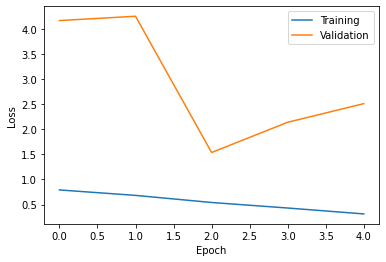

In [219]:
plotting.plot_history(history_s2s_flu)

In [231]:
seq2seq_covid = models.transfer_seq2seq(seq2seq_flu)
seq2seq_covid.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 25, 1)]           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 25, 32)            4352      
_________________________________________________________________
lstm_8 (LSTM)                (None, 25, 32)            8320      
_________________________________________________________________
attention (Attention)        (None, 32)                57        
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 32)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 5, 32)             8320      
_________________________________________________________________
lstm_10 (LSTM)               (None, 5, 32)             8320

In [234]:
history_s2s_cov = seq2seq_flu.fit(ds_train_covid, validation_data=ds_val_covid, epochs=10)

Train for 60 steps, validate for 13 steps
Epoch 1/10
60/60 [==============================] - 2s 38ms/step - loss: 0.0022 - val_loss: 1.9699
Epoch 2/10
60/60 [==============================] - 2s 37ms/step - loss: 0.0025 - val_loss: 1.9812
Epoch 3/10
60/60 [==============================] - 2s 38ms/step - loss: 0.0022 - val_loss: 1.9656
Epoch 4/10
60/60 [==============================] - 2s 37ms/step - loss: 0.0018 - val_loss: 2.0162
Epoch 5/10
60/60 [==============================] - 2s 37ms/step - loss: 0.0017 - val_loss: 1.9760
Epoch 6/10
60/60 [==============================] - 2s 38ms/step - loss: 0.0020 - val_loss: 2.0647
Epoch 7/10
60/60 [==============================] - 2s 37ms/step - loss: 0.0018 - val_loss: 2.0208
Epoch 8/10
60/60 [==============================] - 2s 40ms/step - loss: 0.0014 - val_loss: 2.0640
Epoch 9/10
60/60 [==============================] - 2s 37ms/step - loss: 0.0013 - val_loss: 2.0703
Epoch 10/10
60/60 [==============================] - 2s 37ms/step -

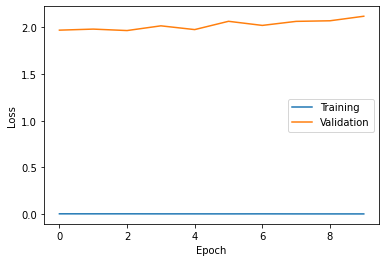

In [235]:
plotting.plot_history(history_s2s_cov)

In [236]:
data_all = []
for dd in (data_dict_flu, data_dict_covid):
    X_all = np.concatenate((dd['X_train'], dd['X_val'], dd['X_test']))
    y_all = np.concatenate((dd['y_train'], dd['y_val'], dd['y_test']))
    states_all = np.concatenate((dd['states_train'], dd['states_val'], dd['states_test']))
    data_all.append((X_all, y_all, states_all))

(X_all_flu, y_all_flu, states_all_flu), (X_all_covid, y_all_covid, states_all_covid) = data_all

RMSES for each step = [0.57001912 0.81093026 1.10531887 1.37091727 1.74791042], average = 1.121019186833061


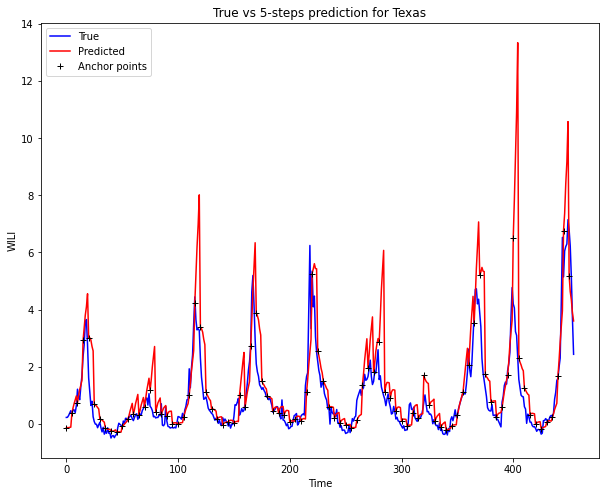

In [244]:
plotting.plot_preds_for_state(X_all_flu, y_all_flu.reshape(-1,TARGET_SIZE), states_all_flu, seq2seq_flu,
                              HISTORY_SIZE, TARGET_SIZE, 'Texas', scaler_flu)

RMSES for each step = [3.50627725 3.95338425 4.16534917 4.32989884 4.49985458], average = 4.090952819792907


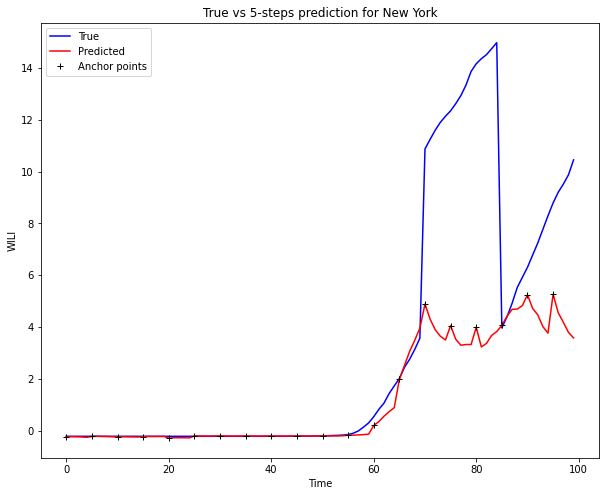

In [243]:
plotting.plot_preds_for_state(X_all_covid, y_all_covid.reshape(-1,TARGET_SIZE), states_all_covid,
                              seq2seq_flu, HISTORY_SIZE, TARGET_SIZE, 'New York', scaler_flu)

## seq2seq model with teacher forcing, sequential prediction

In [488]:
# Resampling the flu data to be daily resolution
from datetime import datetime, timedelta

def parse_date(d):
    yy, ww = d.split('-')
    ystart = datetime(year=int(yy), month=1, day=1)
    dd = ystart + timedelta(days=7 * int(ww))
    return dd

def interpolate(ser):
    res = ser.copy()
    print(res)
    min_, max_ = res[0], res[-1]
    dydx = (max_ - min_) / (len(res) - 1)
    for i in range(len(res)):
        res[i] = i * dydx + min_
    return res

def upsample(df):
    return df['wili'].resample('D').apply(interpolate)

df_flu_res = df_flu.copy()
df_flu_res['time'] = df_flu_res['time'].apply(parse_date)
df_flu_res = df_flu_res.set_index(pd.DatetimeIndex(df_flu_res['time'])).drop('time', axis=1)
df_flu_res = df_flu_res

In [489]:
df_flu_res = df_flu_res.groupby('state').apply(lambda group: (group
                                                              .resample('D')
                                                              .interpolate(method='linear')))


In [490]:
df_flu_res = df_flu_res.drop('state', axis=1).reset_index()

In [491]:
df_flu_res

,state,time,wili
0,Alabama,2010-10-08,2.134770
1,Alabama,2010-10-09,2.124087
2,Alabama,2010-10-10,2.113404
3,Alabama,2010-10-11,2.102721
4,Alabama,2010-10-12,2.092039
...,...,...,...
161245,Wyoming,2019-08-02,0.000000
161246,Wyoming,2019-08-03,0.000000
161247,Wyoming,2019-08-04,0.000000
161248,Wyoming,2019-08-05,0.000000


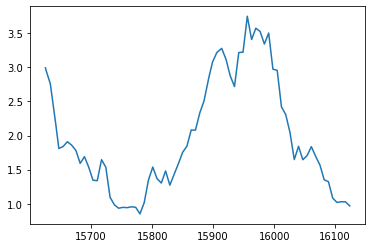

In [492]:
state = 'California'
plt.plot(df_flu_res[df_flu_res['state'] == state]['wili'][-500:])

In [588]:

# Making train/val/test split
# Resampling didn't work
ds_train_flu, ds_val_flu, ds_test_flu, data_dict_flu = time_series.prepare_data(df_flu['wili'].values, 
                                                                                df_flu['state'].values,
                                                                                history_size=HISTORY_SIZE,
                                                                                target_size=TARGET_SIZE,
                                                                                batch_size=BATCH_SIZE,
                                                                                test_size=TEST_SIZE,
                                                                                teacher_forcing=True)

ds_train_covid, ds_val_covid, ds_test_covid, data_dict_covid = time_series.prepare_data(df_covid['cases'].values, 
                                                                                        df_covid['state'].values,
                                                                                        history_size=HISTORY_SIZE,
                                                                                        target_size=TARGET_SIZE,
                                                                                        batch_size=BATCH_SIZE,
                                                                                        test_size=TEST_SIZE,
                                                                                        teacher_forcing=True)

In [589]:
seq2seq_model = models.Seq2Seq(history_length=HISTORY_SIZE,
                               target_length=TARGET_SIZE,
                               hidden_size=HIDDEN_SIZE,
                               pre_output_dense_size=PRE_OUTPUT_DENSE_SIZE,
                               num_encoder_layers=3,
                               dropout=0.2)

In [590]:
seq2seq_model.summary()

Model: "model_161"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_251 (InputLayer)          [(None, 25, 1)]      0                                            
__________________________________________________________________________________________________
encoder_lstm0 (LSTM)            [(None, 25, 32), (No 4352        input_251[0][0]                  
__________________________________________________________________________________________________
encoder_lstm1 (LSTM)            [(None, 25, 32), (No 8320        encoder_lstm0[0][0]              
__________________________________________________________________________________________________
input_252 (InputLayer)          [(None, None, 1)]    0                                            
__________________________________________________________________________________________

In [591]:
history_seq2seq = seq2seq_model.fit(ds_train_flu, validation_data=ds_val_flu, epochs=10)

Train for 236 steps, validate for 51 steps
Epoch 1/10
236/236 [==============================] - 22s 94ms/step - loss: 0.1880 - val_loss: 0.0992
Epoch 2/10
236/236 [==============================] - 14s 59ms/step - loss: 0.1008 - val_loss: 0.0908
Epoch 3/10
236/236 [==============================] - 18s 76ms/step - loss: 0.0970 - val_loss: 0.0819
Epoch 4/10
236/236 [==============================] - 14s 59ms/step - loss: 0.0956 - val_loss: 0.0801
Epoch 5/10
236/236 [==============================] - 13s 56ms/step - loss: 0.0954 - val_loss: 0.0798
Epoch 6/10
236/236 [==============================] - 12s 52ms/step - loss: 0.0946 - val_loss: 0.0804
Epoch 7/10
236/236 [==============================] - 18s 76ms/step - loss: 0.0946 - val_loss: 0.0809
Epoch 8/10
236/236 [==============================] - 14s 60ms/step - loss: 0.0933 - val_loss: 0.0833
Epoch 9/10
236/236 [==============================] - 14s 60ms/step - loss: 0.0935 - val_loss: 0.0791
Epoch 10/10
236/236 [==================

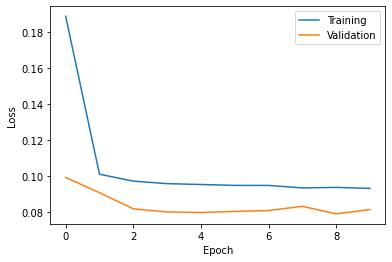

In [592]:
plotting.plot_history(history_seq2seq)

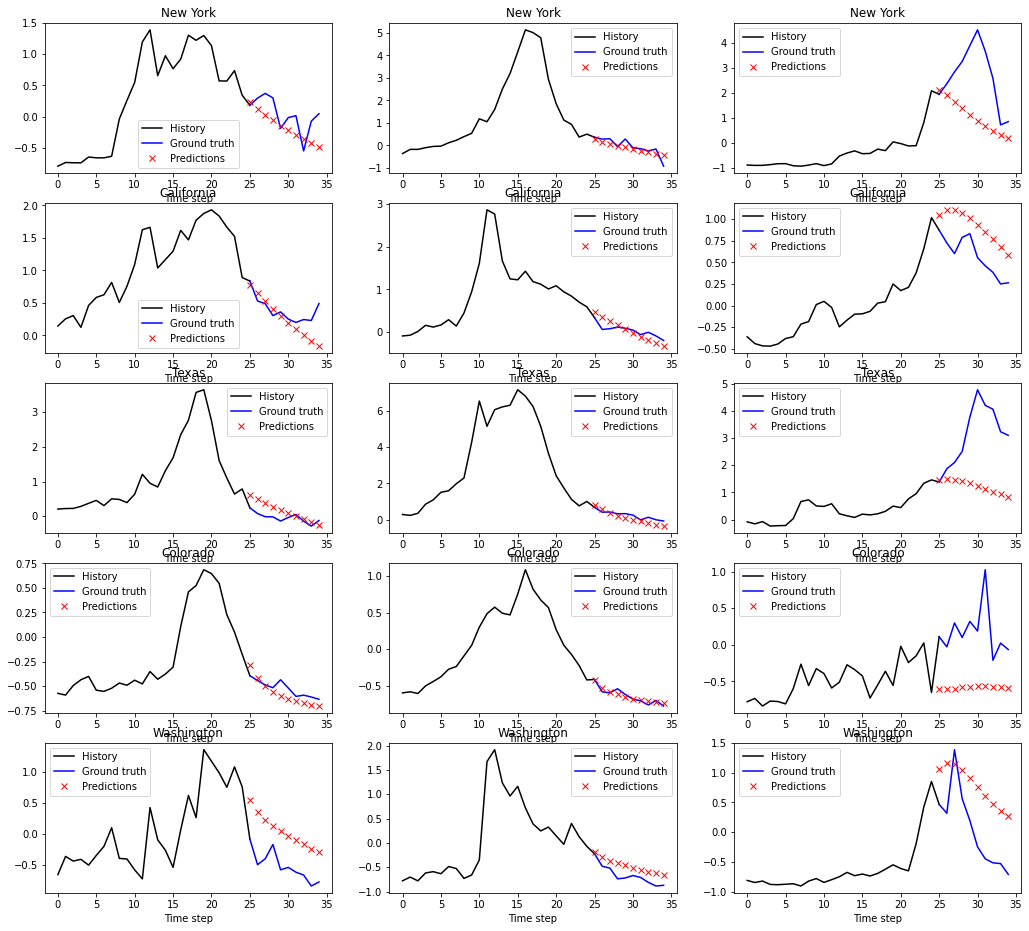

In [593]:
states = ['New York', 'California', 'Texas', 'Colorado', 'Washington']
fig, axs = plt.subplots(len(states), 3, figsize=(3.5 * len(states), 16))
for i, state in enumerate(states):
    for j, split in enumerate(['train', 'val', 'test']):
        plotting.plot_seq2seq_preds(seq2seq_model, data_dict_flu, state, 10, scaler=scaler_flu, split=split, ax=axs[i, j])
        axs[i, j].set_title(state)
plt.show()

## Transferring to COVID

In [594]:
seq2seq_covid_tl = seq2seq_model.transfer()
seq2seq_covid_tl.summary()

Model: "model_164"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_255 (InputLayer)          [(None, 25, 1)]      0                                            
__________________________________________________________________________________________________
encoder_lstm0 (LSTM)            [(None, 25, 32), (No 4352        input_255[0][0]                  
__________________________________________________________________________________________________
encoder_lstm1 (LSTM)            [(None, 25, 32), (No 8320        encoder_lstm0[0][0]              
__________________________________________________________________________________________________
input_256 (InputLayer)          [(None, None, 1)]    0                                            
__________________________________________________________________________________________

In [595]:
history_seq2seq_cov = seq2seq_covid_tl.fit(ds_train_covid, validation_data=ds_val_covid, epochs=10)

Train for 14 steps, validate for 4 steps
Epoch 1/10
14/14 [==============================] - 11s 796ms/step - loss: 0.0438 - val_loss: 0.1851
Epoch 2/10
14/14 [==============================] - 1s 59ms/step - loss: 0.0165 - val_loss: 0.0945
Epoch 3/10
14/14 [==============================] - 1s 59ms/step - loss: 0.0077 - val_loss: 0.0709
Epoch 4/10
14/14 [==============================] - 1s 55ms/step - loss: 0.0053 - val_loss: 0.0644
Epoch 5/10
14/14 [==============================] - 1s 55ms/step - loss: 0.0036 - val_loss: 0.0706
Epoch 6/10
14/14 [==============================] - 1s 55ms/step - loss: 0.0030 - val_loss: 0.0488
Epoch 7/10
14/14 [==============================] - 1s 55ms/step - loss: 0.0033 - val_loss: 0.0736
Epoch 8/10
14/14 [==============================] - 1s 54ms/step - loss: 0.0023 - val_loss: 0.0511
Epoch 9/10
14/14 [==============================] - 1s 53ms/step - loss: 0.0021 - val_loss: 0.0479
Epoch 10/10
14/14 [==============================] - 1s 68ms/step 

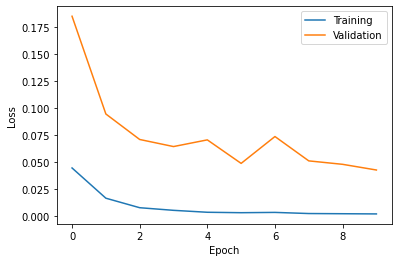

In [596]:
plotting.plot_history(history_seq2seq_cov)

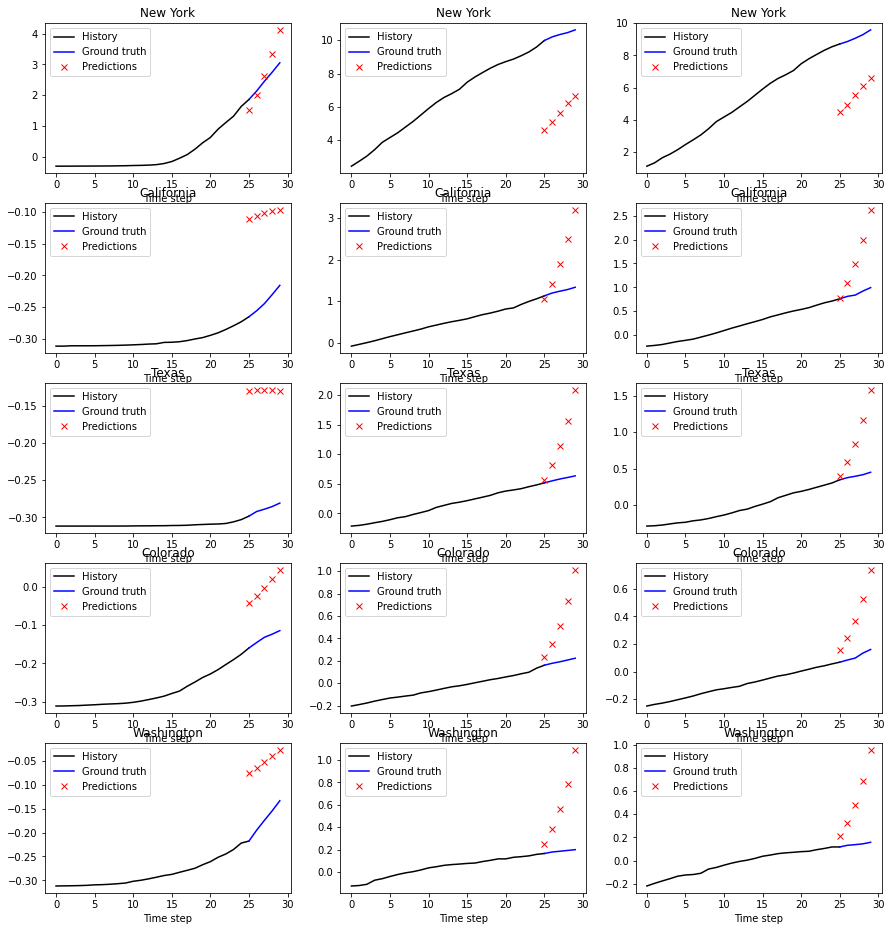

In [597]:
states = ['New York', 'California', 'Texas', 'Colorado', 'Washington']
fig, axs = plt.subplots(len(states), 3, figsize=(3 * len(states), 16))
for i, state in enumerate(states):
    for j, split in enumerate(['train', 'val', 'test']):
        plotting.plot_seq2seq_preds(seq2seq_covid_tl, data_dict_covid, state, 5, scaler=scaler_flu, split=split, ax=axs[i, j])
        axs[i, j].set_title(state)
plt.show()

## Trying a seq2seq without transferring for COVID

In [569]:
seq2seq_covid = models.Seq2Seq(history_length=HISTORY_SIZE,
                               target_length=TARGET_SIZE,
                               hidden_size=HIDDEN_SIZE,
                               pre_output_dense_size=PRE_OUTPUT_DENSE_SIZE,
                               num_encoder_layers=3,
                               dropout=0.2)
seq2seq_covid.summary()

Model: "model_148"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_234 (InputLayer)          [(None, 25, 1)]      0                                            
__________________________________________________________________________________________________
encoder_lstm0 (LSTM)            [(None, 25, 32), (No 4352        input_234[0][0]                  
__________________________________________________________________________________________________
encoder_lstm1 (LSTM)            [(None, 25, 32), (No 8320        encoder_lstm0[0][0]              
__________________________________________________________________________________________________
input_235 (InputLayer)          [(None, None, 1)]    0                                            
__________________________________________________________________________________________

In [570]:
history_cov_alone = seq2seq_covid.fit(ds_train_covid, validation_data=ds_val_covid, epochs=15)

Train for 45 steps, validate for 11 steps
Epoch 1/15
45/45 [==============================] - 13s 281ms/step - loss: 0.0851 - val_loss: 2.5468
Epoch 2/15
45/45 [==============================] - 3s 56ms/step - loss: 0.0243 - val_loss: 2.7708
Epoch 3/15
45/45 [==============================] - 2s 55ms/step - loss: 0.0060 - val_loss: 2.4050
Epoch 4/15
45/45 [==============================] - 2s 51ms/step - loss: 0.0035 - val_loss: 2.4552
Epoch 5/15
45/45 [==============================] - 2s 51ms/step - loss: 0.0025 - val_loss: 1.4827
Epoch 6/15
45/45 [==============================] - 2s 52ms/step - loss: 0.0029 - val_loss: 1.5384
Epoch 7/15
45/45 [==============================] - 2s 52ms/step - loss: 0.0025 - val_loss: 1.0782
Epoch 8/15
45/45 [==============================] - 2s 50ms/step - loss: 0.0020 - val_loss: 0.9881
Epoch 9/15
45/45 [==============================] - 2s 51ms/step - loss: 0.0017 - val_loss: 0.8390
Epoch 10/15
45/45 [==============================] - 2s 52ms/step

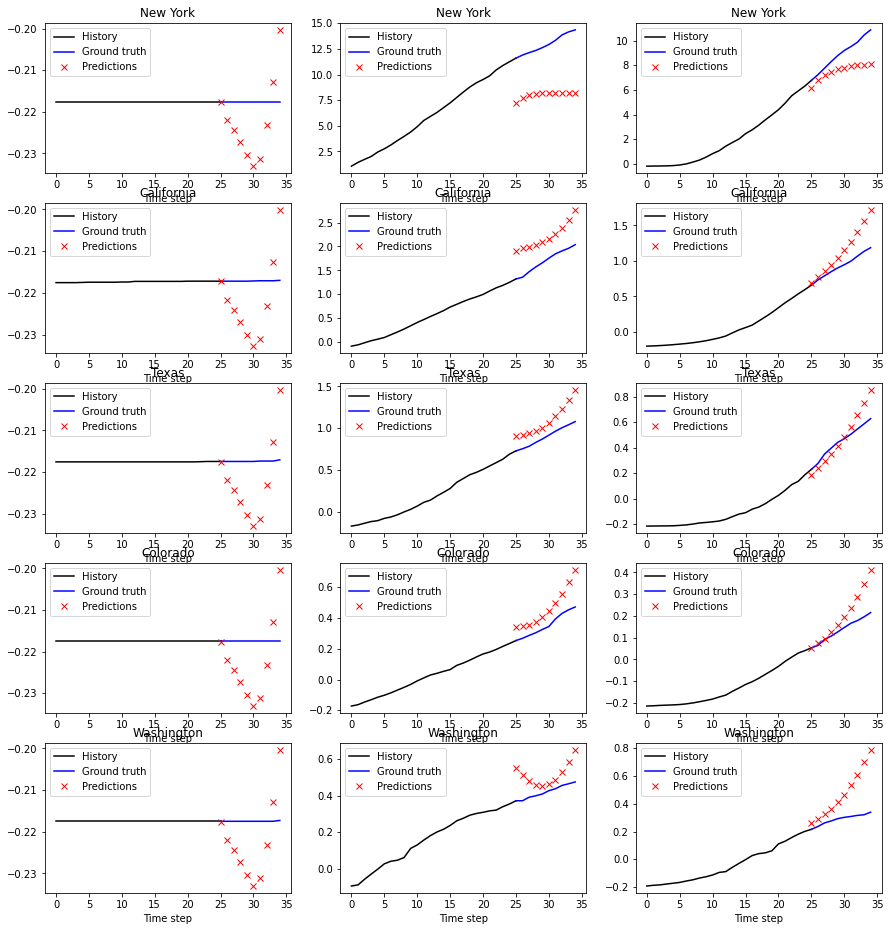

In [571]:
states = ['New York', 'California', 'Texas', 'Colorado', 'Washington']
fig, axs = plt.subplots(len(states), 3, figsize=(3 * len(states), 16))
for i, state in enumerate(states):
    for j, split in enumerate(['train', 'val', 'test']):
        plotting.plot_seq2seq_preds(seq2seq_covid, data_dict_covid, state, 10, scaler=scaler_flu, split=split, ax=axs[i, j])
        axs[i, j].set_title(state)
plt.show()